# Coursework 1: Chest X-ray (100 marks)

In this coursework, you will be working with the Kaggle [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data) dataset. You will analyze the dataset, and train deep learning models to classify whether an x-ray exhibits pneumonia.


The coursework is structured as follows:

1. Data Analysis: 5 marks
2. Data Preparation: 5 marks
3. Training a Baseline: 30 marks
4. Improving the Baseline: 50 marks
5. Evaluating on the Test Set: 10 marks

In each question will require you tocode up a solution, and to briefly explain and discuss your choices and results.

__IMPORTANT__
* Pretrained models are __NOT__ allowed. You will recieve __0__ marks for any use of pretrained models.
* The use of LLM/AI support including writing and coding aligns to the UCL guidelines. This includes the use of code prompts and Gemini in Google Collab

Here are some additional tips:
- We recommend using weights and biases to log your training runs. This will allow you to easily compare previous runs if needed.
- Ensure your results are reproducable - we may rerun your notebook to check for this. Points will be lost if results are not reproducable.
- We recommend factorizing your code in places where you will be repeatedly using the same functionaility. For example, if you are training multiple models, consider using a common training loop function.
- Your code and results and discussions should be concise, well-presented, and easy to read. Each question has a certain portion of marks going towards this.
- Ensure you correctly use the train, validation, and test set throughout. You should only ever use the test set once - for the final evaluation.
- Consider saving your models so you can reload previous models for the final evaluation
- Ensure it is clear to the reader what any plots / figures are presenting. I.e., label axes, include titles, ensure it is clear what experiment it is from (what model / design choices, etc.)
- Google Collab restricts the amount of GPU time available. Consider debugging code, using a subset of data, on CPU compute

In [2]:
!pip install kaggle
!pip install wandb

If you get the following error when running the import cell below this description:


```
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
```
You will need to create a kaggle account, and navigate to https://www.kaggle.com/me/account. Navigate to "API" and create a new token. This will automatically download a json file called "kaggle.json".

Run the following code, replacing the "INSERT JSON HERE TEXT" with the contents of the json that you downloaded.

```
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

api_token = INSERT JSON HERE TEXT

import json

with open('/root/.config/kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.config/kaggle/kaggle.json
```

INSERT JSON HERE TEXT should be something of the form:
```
{"username":"XXX","key":"XXX"}
```

In [3]:
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

api_token = {"username":"tanishqpatil13","key":"ad88357d82fbbc187a7c9e5d780109f6"}

import json

with open('/root/.config/kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.config/kaggle/kaggle.json

In [4]:
import os
import random
import shutil
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
import numpy as np

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb

In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

# Load and Re-split the Raw Data

The original data is poorly split, so we will resplit it here. Do NOT edit this code.

In [6]:
# Hyperparameters
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1  # This is implicitly defined as 1 - (TRAIN_SPLIT + VAL_SPLIT)

In [7]:
# Set up the Kaggle API
api = KaggleApi()
api.authenticate()

# Specify the dataset
dataset = "paultimothymooney/chest-xray-pneumonia"

# Specify the download path
download_path = "chest_xray_dataset"

# Check if the dataset is already downloaded
if os.path.exists(os.path.join(download_path, "chest_xray")):
    print(f"Dataset already exists at {download_path}. Skipping download.")
else:
    # Create the download directory if it doesn't exist
    os.makedirs(download_path, exist_ok=True)

    # Download the dataset
    print(f"Downloading {dataset} to {download_path}")
    api.dataset_download_files(dataset, path=download_path, unzip=True)
    print("Download complete!")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
Download complete!


In [8]:
# Re-split data
dataset_path = os.path.join(download_path, "chest_xray")
new_dataset_path = "chest_xray_dataset_new_split"

if not os.path.exists(new_dataset_path):
    # Create new directory structure
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(os.path.join(new_dataset_path, split, cls), exist_ok=True)

    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = os.path.join(dataset_path, split, cls)
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])

        # Sort files to ensure consistent order before shuffling
        all_files.sort()

        # Create a new Random object with the seed
        rng = random.Random(42)

        # Use the shuffle method of the Random object
        rng.shuffle(all_files)

        total_files = len(all_files)
        train_end = int(total_files * TRAIN_SPLIT)
        val_end = int(total_files * (TRAIN_SPLIT + VAL_SPLIT))

        train_files = all_files[:train_end]
        val_files = all_files[train_end:val_end]
        test_files = all_files[val_end:]

        for split, file_list in [('train', train_files), ('val', val_files), ('test', test_files)]:
            for file, source_folder in file_list:
                source = os.path.join(source_folder, file)
                dest = os.path.join(new_dataset_path, split, cls, file)
                shutil.copy(source, dest)

    print(f"Data re-split complete. New dataset location: {new_dataset_path}")
else:
    print(f"Re-split dataset already exists at {new_dataset_path}")

Data re-split complete. New dataset location: chest_xray_dataset_new_split


# Question 1: Data Analysis (5 marks)

Perform some basic analysis of the statistics of the dataset.

Try to spot anything that may impact how you will design your deep learning classifier and training.

We'd expect to see:
* Analysis of labels (target variable);
* Analysis of input features;

If you do spot anything, briefly explain **how you think it may impact training**.


In [9]:
# Collect dataset statistics
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

stats = {split: {cls: 0 for cls in ['NORMAL', 'PNEUMONIA']} for split in ['train', 'val', 'test']}
for split in splits:
    for cls in classes:
        path = os.path.join(new_dataset_path, split, cls)
        stats[split][cls] = len(os.listdir(path))

print(json.dumps(stats, sort_keys=True, indent=4))

{
    "test": {
        "NORMAL": 159,
        "PNEUMONIA": 428
    },
    "train": {
        "NORMAL": 1266,
        "PNEUMONIA": 3418
    },
    "val": {
        "NORMAL": 158,
        "PNEUMONIA": 427
    }
}


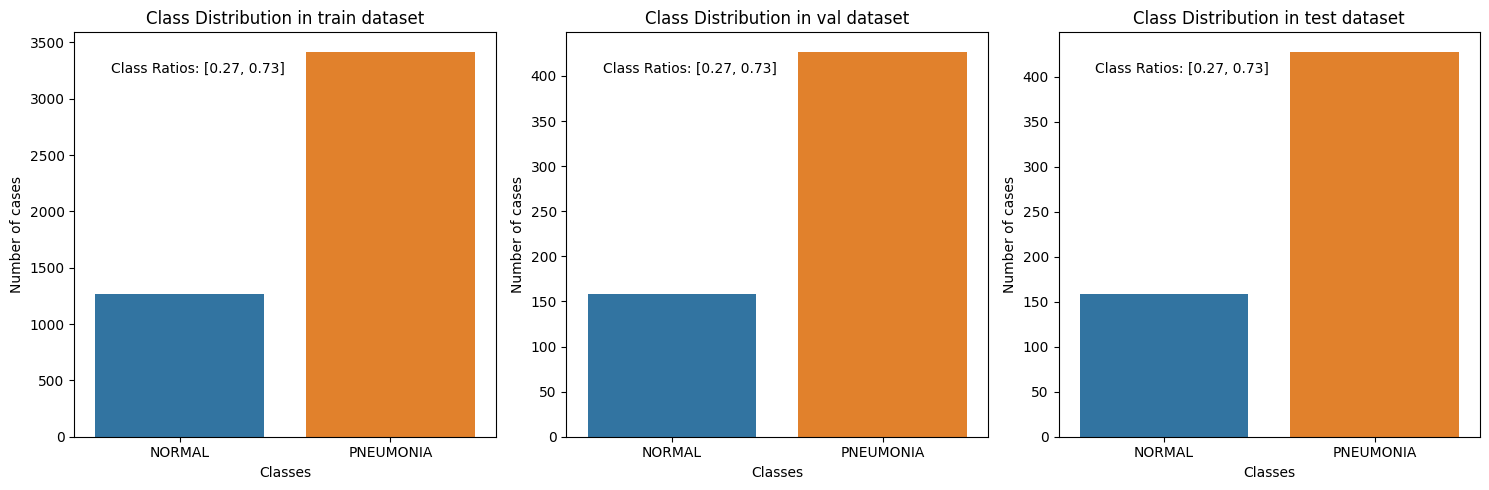

In [ ]:
########################################################################
#                              YOUR CODE HERE                          #
########################################################################

# Analysis of labels (target variable)

import seaborn as sns

def calculate_class_ratios(stats_split):
  class_ratios = []
  for cls in stats_split.keys():
    class_ratios.append(round(stats_split[cls] / sum(stats_split.values()), 2))
  return class_ratios


fig, axs = plt.subplots(1, 3, figsize = (15, 5))
for i, split in enumerate(splits):
  sns.barplot(x = stats[split].keys(), y = stats[split].values(), ax = axs[i], hue = stats[split].keys())
  axs[i].set_xlabel('Classes')
  axs[i].set_ylabel('Number of cases')
  axs[i].set_title(f'Class Distribution in {split} dataset')
  axs[i].text(0.5, 0.9, f'Class Ratios: {calculate_class_ratios(stats[split])}', transform=axs[i].transAxes, ha='right')

plt.tight_layout()
plt.show()

20 samples from the Chest X-Ray image dataset:


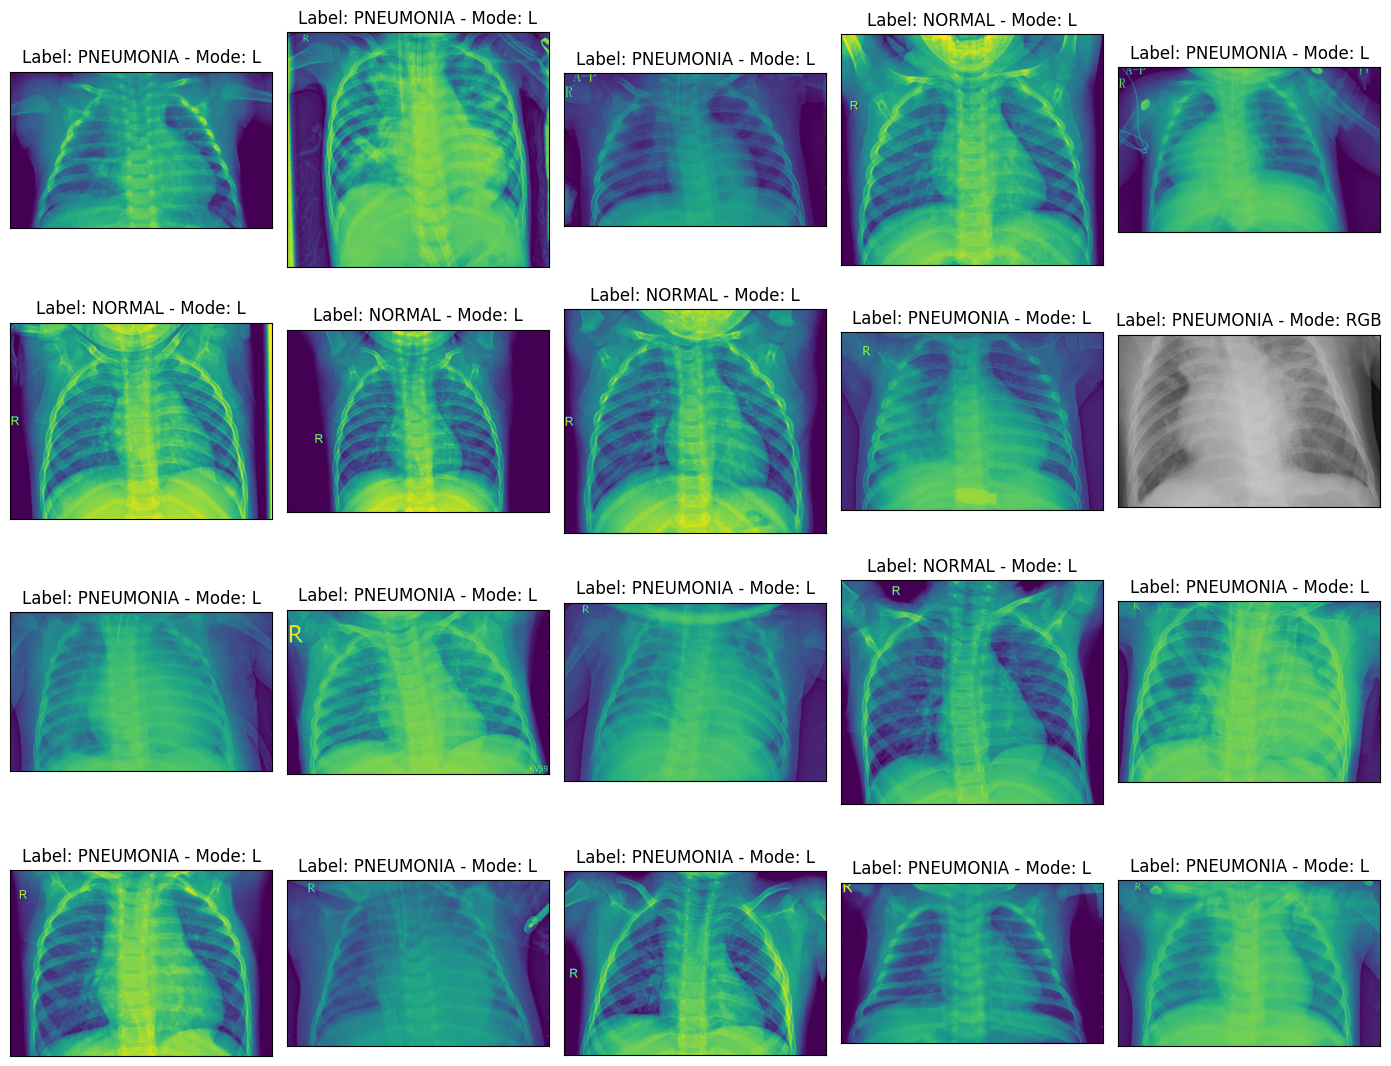

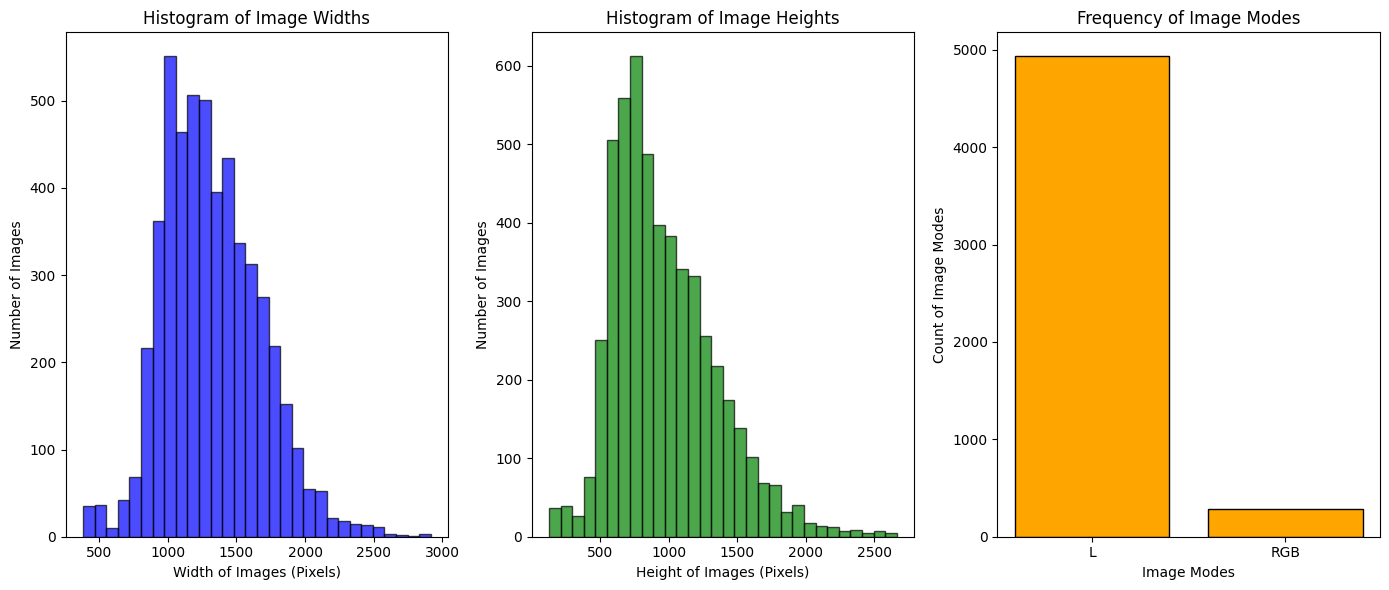



Mean Width: 1320.6108128834355
Mean Height: 968.0747699386503


Standard Deviation of Width: 355.26468302630497
Standard Deviation of Height: 378.81937266835075


Number of missing labels: 0


In [ ]:
# Analysis of input features

from torchvision import datasets

training_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'train'))
widths, heights, image_modes = [], [], []
missing_labels = 0

label_list = ['NORMAL', 'PNEUMONIA']
sample_indices = random.sample(range(len(training_dataset)), 20)
fig = plt.figure(figsize=(14, 12))
itr = 0
print("20 samples from the Chest X-Ray image dataset:")
for i in sample_indices:
    cls = ''
    image_path, label = training_dataset.imgs[i]
    ax = fig.add_subplot(4, 5, itr + 1, xticks=[], yticks=[])
    image = Image.open(image_path)
    ax.imshow(image)
    ax.set_title(f'Label: {label_list[label]} - Mode: {image.mode}')
    fig.tight_layout()
    itr += 1
plt.show()

print("\n")

for image_path, label in training_dataset.imgs:
    if np.isnan(label):
      missing_labels += 1
    original_image = Image.open(image_path)
    width, height = original_image.size
    widths.append(width)
    heights.append(height)
    image_modes.append(original_image.mode)

mode_counts = Counter(image_modes)
modes = list(mode_counts.keys())
counts = list(mode_counts.values())

# Plotting distributions
plt.figure(figsize=(14, 6))

# Histogram for widths
plt.subplot(1, 3, 1)
plt.hist(widths, bins=30, color='blue', alpha=0.7, edgecolor = 'black')
plt.title('Histogram of Image Widths')
plt.xlabel('Width of Images (Pixels)')
plt.ylabel('Number of Images')

# Histogram for heights
plt.subplot(1, 3, 2)
plt.hist(heights, bins=30, color='green', alpha=0.7, edgecolor = 'black')
plt.title('Histogram of Image Heights')
plt.xlabel('Height of Images (Pixels)')
plt.ylabel('Number of Images')

# Barplot for image modes
plt.subplot(1, 3, 3)
plt.bar(modes, counts, color='orange', edgecolor = 'black')
plt.title('Frequency of Image Modes')
plt.xlabel('Image Modes')
plt.ylabel('Count of Image Modes')

plt.tight_layout()
plt.show()

mean_width, mean_height = np.mean(widths), np.mean(heights)
std_width, std_height = np.std(widths), np.std(heights)
print("\n")
print(f"Mean Width: {mean_width}")
print(f"Mean Height: {mean_height}")
print("\n")
print(f"Standard Deviation of Width: {std_width}")
print(f"Standard Deviation of Height: {std_height}")
print("\n")
print(f"Number of missing labels: {missing_labels}")

**(a)**

_Insert brief discussion of analysis here_


1.   Analysis of labels - Class Distribution in different datasets:
     1. The class ratios ([0.27, 0.73]) shown on the class distribution plots indicate that the datasets are imbalanced, with approximately 27% being the "NORMAL" class samples, and remaining 73% belonging to "PNEUMONIA" class
     2. This class ratio is consistent across all the three distributions - 'train', 'val', and 'test'
     3. This imbalance will lead to bias in training towards pneumonic samples, therefore we need to mitigate this bias

2.   Analysis of input features:
     1. The dimensions of images are not same, hence these images require resizing as part of the pre-processing to have a standard dataset
     2. The mean width x height of the dataset is: 1324 x 968
     3. The 'L' image mode is the predominant mode with close to 5000 images, and 'RGB' is present in a very smaller proportion with approximately 250 instances




# Question 2: Data Preparation (5 marks)

Here, you should load the dataset into torch dataloaders, performing any preprocessing required in the process.

Within the ChestXrayDataset class, the root_dir parameter is a string defining the directory containing the "train", "val" and "test" folders.

In [10]:
dataset_path = "chest_xray_dataset_new_split"
batch_size = 128

In [11]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, use_aug=False):
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.image_dataset = datasets.ImageFolder(
            os.path.join(self.root_dir, self.split),
            transform = None
            )
        self.use_aug = use_aug

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def __len__(self):
        return len(self.image_dataset)

    def __getitem__(self, idx):
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
        image, label = self.image_dataset[idx]

        # Augmenting the "NORMAL" labelled image dataset with different ColorJitter options and random blurring
        if self.use_aug and label == 0 and self.split == 'train':
            # Augment less than 80% of the "NORMAL" images
            if random.random() < 0.8:
                image = self.transform(image)
            # For "NORMAL" images not meant to be augmented
            else:
                transform_img = transforms.Compose([
                    transforms.Resize((resize_width, resize_height)),
                    transforms.ToTensor()
                ])
                image = transform_img(image)
        # For "PNEUMONIA" images
        else:
            image = self.transform(image)

        return image, label

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [12]:
# Define data transforms
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

resize_width, resize_height = 128, 128
transform = transforms.Compose([
    transforms.Resize((resize_width, resize_height)),
    transforms.ToTensor()
    ])

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [13]:
# Set random seed/state for better reproducibility
def set_random_state(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)

In [14]:
# Create datasets
from torchvision import datasets

training_data = ChestXrayDataset(dataset_path, 'train', transform)
validation_data = ChestXrayDataset(dataset_path, 'val', transform)
testing_data = ChestXrayDataset(dataset_path, 'test', transform)

set_random_state(42)

# Create data loaders
train_loader = DataLoader(
    training_data,
    batch_size = batch_size,
    shuffle = True
    )

val_loader = DataLoader(
    validation_data,
    batch_size = batch_size,
    shuffle = True
    )

test_loader = DataLoader(
    testing_data,
    batch_size = batch_size
    )

# Print dataset sizes
print(f"Training dataset size: {len(training_data)}")
print(f"Validation dataset size: {len(validation_data)}")
print(f"Test dataset size: {len(testing_data)}")

# Print batch shapes
print(f"Train Dataloader Shape: {next(iter(train_loader))[0].shape}")
print(f"Validation Dataloader Shape: {next(iter(val_loader))[0].shape}")
print(f"Test Dataloader Shape: {next(iter(test_loader))[0].shape}")

# Print the label list batch being used for validation
print(f"Validation Dataloader Labels: {next(iter(val_loader))[1]}")

Training dataset size: 4684
Validation dataset size: 585
Test dataset size: 587
Train Dataloader Shape: torch.Size([128, 3, 128, 128])
Validation Dataloader Shape: torch.Size([128, 3, 128, 128])
Test Dataloader Shape: torch.Size([128, 3, 128, 128])
Validation Dataloader Labels: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 0, 0])


**(a)**

_Insert brief discussion of any design choices you made here_

1. Started with the moderate batch_size of 128
2. ChestXrayDataset class contains the logic to apply data augmentation tranformation to minority class for handling the class imbalance in the improved model
3. Resized all the images to the optimum size of 128x128 so that the computational resources consumption can be reduced and the information present in the images is not lost. Tested the model training with the size of **mean_width** x **mean_height**, **512** x **512**, and **256** x **256**, but the resource consumption and training time were quite high
3. Set the random state to 42 to ensure reproducibility
4. Shuffled all the 3 dataset batches to avoid any particular ordering of features and labels

# Question 3: Training a Baseline (30 marks)

You will now establish an initial baseline model and training procedure. This should be as simple as possible, without using any elaborate design choices, whilst still obtaining reasonable performance (i.e., at least better than random chance). You will attempt to improve upon this baseline in later questions.

When answering this question, consider what makes a good baseline:
* Easily converges;
* Easy to implement;
* Established architectural components that have proved well suited to the data-type and problem.
* Obtains reasonable performance e.g, better than random guess

You will be required to explain your design choices, and to present and discuss you results.

The code below is a suggested structure to guide you. You are free to deviate from this __however, it must be obvious to the marker__:
* What the final proposed baseline model is (in terms of architecture);
* What the performance of the baseline model is and how the model has been trained;
* What your written justification and discussion is;



In [15]:
num_epochs = 20
use_wandb = True  # Set to True if you want to use wandb
lr = 1e-2

In [ ]:
# Define the model
class SimpleModel(nn.Module):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
    def __init__(self):
        super().__init__()

        # Convolutional Neural Network Layers
        self.conv_layer_stack = nn.Sequential(

            # CNN Layer 1
            nn.Conv2d(3, 16, (3, 3)),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),

            # CNN Layer 2
            nn.Conv2d(16, 8, (3, 3)),
            nn.ReLU()
        )

        # Classification Layer for prediction
        self.classification_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear((int((resize_width-2)/2)-2)*(int((resize_height-2)/2)-2)*8, 2)
        )

    def forward(self, x):
        x = self.conv_layer_stack(x)
        x = self.classification_layer(x)
        return x

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################


In [16]:
def calculate_class_accuracy(outputs, labels):
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).squeeze()

        class_accuracy = {}
        for cls_label in torch.unique(labels):
            class_accuracy[cls_label.item()] = (correct[predicted == cls_label]).sum().item() * 100 / (labels == cls_label).sum().item()
        return class_accuracy

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [17]:
def val_test_model(split_type, model, val_test_loader, criterion, device='cuda', use_wandb=False, plot_cls_metrics=False):
        model.eval()

        val_test_loss, correct, total = 0, 0, 0
        all_labels, all_preds = [], []

        with torch.no_grad():
          for X_batch, y_batch in val_test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            val_test_loss += loss.item()
            total += y_batch.size(0)
            _, predicted = torch.max(y_pred.data, 1)
            correct += (predicted == y_batch).sum().item()

            all_labels.append(y_batch)
            all_preds.append(y_pred)

        epoch_val_loss = val_test_loss / len(val_test_loader)
        epoch_val_accuracy = correct * 100 / total

        all_labels = torch.cat(all_labels, dim=0)
        all_preds = torch.cat(all_preds, dim=0)
        epoch_val_class_accuracy = calculate_class_accuracy(all_preds, all_labels)

        print(f"Epoch {split_type} Loss: {epoch_val_loss}")
        print(f"Epoch {split_type} Accuracy: {epoch_val_accuracy}")
        print(f"Epoch {split_type} Class Accuracy: {epoch_val_class_accuracy}")
        print("\n")

        # Call the method to plot ROC Curve, Precision-Recall Curve, and calculate F1 Score
        if plot_cls_metrics:
          plot_classification_metrics(all_labels, all_preds)

        return epoch_val_loss, epoch_val_accuracy, epoch_val_class_accuracy

In [17]:
def train_single_epoch(model, train_loader, criterion, optimizer, device='cuda', use_wandb=False, plot_cls_metrics=False):
        train_loss, total, correct  = 0, 0, 0
        all_labels, all_preds = [], []

        model.train()

        for X_train, y_train in train_loader:
          X_train, y_train = X_train.to(device), y_train.to(device)

          optimizer.zero_grad()
          y_pred = model(X_train)
          loss = criterion(y_pred, y_train)

          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

          train_loss += loss.item()
          total += y_train.size(0)
          _, predicted = torch.max(y_pred.data, 1)

          correct += (predicted == y_train).sum().item()
          all_labels.append(y_train)
          all_preds.append(y_pred)

        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_accuracy = correct * 100 / total

        all_labels = torch.cat(all_labels, dim=0)
        all_preds = torch.cat(all_preds, dim=0)
        epoch_train_class_accuracy = calculate_class_accuracy(all_preds, all_labels)

        print(f"Epoch Train Loss: {epoch_train_loss}")
        print(f"Epoch Train Accuracy: {epoch_train_accuracy}")
        print(f"Epoch Train Class Accuracy: {epoch_train_class_accuracy}")
        print("\n")

        # Call the method to plot ROC Curve, Precision-Recall Curve, and calculate F1 Score
        if plot_cls_metrics:
          plot_classification_metrics(all_labels, all_preds)

        return epoch_train_loss, epoch_train_accuracy, epoch_train_class_accuracy

In [18]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, device='cuda', use_wandb=False, scheduler=None):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

# Feel free to add more intermediate functions to do this

        train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
        train_class_accuracies, val_class_accuracies = {}, {}
        best_val_loss = float('inf')

        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}\n-------------------------------")

            # Train the model
            epoch_train_loss, epoch_train_accuracy, epoch_train_class_accuracy = train_single_epoch(model, train_loader, criterion, optimizer, device, use_wandb, (epoch==num_epochs-1))
            train_losses.append(epoch_train_loss)
            train_accuracies.append(epoch_train_accuracy)
            train_class_accuracies[epoch] = epoch_train_class_accuracy

            # Validate the trained model
            epoch_val_loss, epoch_val_accuracy, epoch_val_class_accuracy = val_test_model('Validation', model, val_loader, criterion, device, use_wandb, (epoch==num_epochs-1))
            val_losses.append(epoch_val_loss)
            val_accuracies.append(epoch_val_accuracy)
            val_class_accuracies[epoch] = epoch_val_class_accuracy

            # Log losses, gradients, checkpoints to wandb
            if use_wandb:
                wandb.log({"train_loss": epoch_train_loss, "val_loss": epoch_val_loss})

                current_lr = optimizer.param_groups[0]['lr']
                wandb.log({"learning_rate": current_lr})

                for name, param in model.named_parameters():
                        if param.grad is not None:
                                wandb.log({f"gradients/{name}": wandb.Histogram(param.grad.cpu().numpy())})

                if epoch_val_loss < best_val_loss:
                        best_val_loss = epoch_val_loss
                        chkp_pth = os.path.join(wandb.run.dir, f"chestXRay_mdl_chkpnt_epoch_{epoch}.pt")
                        torch.save(
                                {
                                'epoch': epoch,
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                }, chkp_pth)
                        # Log the path of the best model checkpoint
                        wandb.log({"best_model_path": chkp_pth})

            else:
                if ((epoch+1) % 5 == 0):
                        torch.save({
                                'epoch': epoch,
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                }, f'chestXRay_checkpoint_{(epoch+1)/5}')

            # Use learning rate scheduler
            if scheduler:
                   scheduler.step()



        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies


In [19]:
def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

# Add all your plotting code here. Feel free to use intermediate functions

        epochs = np.arange(1, num_epochs+1)
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))

        # Plot the Training and Validation Losses each epoch
        axs [0, 0].plot(epochs, train_losses, label='Training Loss')
        axs [0, 0].plot(epochs, val_losses, label='Validation Loss')
        axs [0, 0].set_xlabel('Epochs')
        axs [0, 0].set_xticks(np.arange(0, num_epochs+2, 2))
        axs [0, 0].set_ylabel('Loss')
        axs [0, 0].legend()
        axs [0, 0].set_title('Training and Validation Loss')
        axs [0, 0].grid(True)

        # Plot the Training and Validation Accuracy each epoch
        axs [0, 1].plot(epochs, train_accuracies, label='Training Accuracy')
        axs [0, 1].plot(epochs, val_accuracies, label='Validation Accuracy')
        axs [0, 1].set_xlabel('Epochs')
        axs [0, 1].set_xticks(np.arange(0, num_epochs+2, 2))
        axs [0, 1].set_ylabel('Accuracy (%)')
        axs [0, 1].legend()
        axs [0, 1].set_title('Training and Validation Accuracy')
        axs [0, 1].grid(True)

        # Extract class accuracies for plotting
        train_normal_accuracies = [epoch_data.get(0, 0) for epoch_data in train_class_accuracies.values()]
        train_pneumonia_accuracies = [epoch_data.get(1, 0) for epoch_data in train_class_accuracies.values()]
        val_normal_accuracies = [epoch_data.get(0, 0) for epoch_data in val_class_accuracies.values()]
        val_pneumonia_accuracies = [epoch_data.get(1, 0) for epoch_data in val_class_accuracies.values()]

        # Plot the comparison of NORMAL and PNEUMONIA class accuracies for training dataset
        axs [1, 0].plot(epochs, train_normal_accuracies, label='Normal')
        axs [1, 0].plot(epochs, train_pneumonia_accuracies, label='Pneumonia')
        axs [1, 0].set_xlabel('Epochs')
        axs [1, 0].set_xticks(np.arange(0, num_epochs+2, 2))
        axs [1, 0].set_ylabel('Class Accuracy (%)')
        axs [1, 0].legend()
        axs [1, 0].set_title('Training Class Accuracy')
        axs [1, 0].grid(True)

        # Plot the comparison of NORMAL and PNEUMONIA class accuracies for validation dataset
        axs [1, 1].plot(epochs, val_normal_accuracies, label='Normal')
        axs [1, 1].plot(epochs, val_pneumonia_accuracies, label='Pneumonia')
        axs [1, 1].set_xlabel('Epochs')
        axs [1, 1].set_xticks(np.arange(0, num_epochs+2, 2))
        axs [1, 1].set_ylabel('Class Accuracy (%)')
        axs [1, 1].legend()
        axs [1, 1].set_title('Validation Class Accuracy')
        axs [1, 1].grid(True)

        plt.tight_layout()
        plt.show()

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [18]:
import sklearn.metrics as metrics

# Plot the ROC Curve, Precision-Recall Curve, and calculate F1 Score for all the datasets
def plot_classification_metrics(labels, preds):
    probs = torch.sigmoid(preds)
    labels = labels.detach().cpu().numpy()
    probs = probs.detach().cpu().numpy()
    positive_probs = probs[:, 1]

    # Plot ROC Curve and calculate AUC
    fpr, tpr, thresholds = metrics.roc_curve(labels, positive_probs)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot Precision-Recall Curve and calculate AUC
    precision, recall, thresholds = metrics.precision_recall_curve(labels, positive_probs)
    pr_auc = metrics.auc(recall, precision)

    # Claculate F1 Score
    predicted_labels = (np.array(positive_probs) > 0.5).astype(int)
    f1 = metrics.f1_score(labels, predicted_labels)


    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(fpr, tpr, color='blue', label='ROC AUC = %0.2f' % roc_auc)
    axs[0].plot([0, 1], [0, 1], color='grey', linestyle='--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('Receiver Operating Characteristic')
    axs[0].legend(loc='lower right')

    axs[1].plot(recall, precision, color='blue', label='PR AUC = %0.2f' % pr_auc)
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title('Precision-Recall Curve')
    axs[1].legend(loc='lower left')

    plt.tight_layout()
    plt.show()

    print(f"F1 Score: {f1}")


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Epoch 1
-------------------------------
Epoch Train Loss: 0.5651913406075658
Epoch Train Accuracy: 72.13919726729291
Epoch Train Class Accuracy: {0: 4.660347551342812, 1: 97.13282621416033}


Epoch Validation Loss: 0.4870624244213104
Epoch Validation Accuracy: 73.84615384615384
Epoch Validation Class Accuracy: {0: 3.1645569620253164, 1: 100.0}


Epoch 2
-------------------------------
Epoch Train Loss: 0.4740672989471539
Epoch Train Accuracy: 76.77198975234842
Epoch Train Class Accuracy: {0: 32.38546603475513, 1: 93.21240491515506}


Epoch Validation Loss: 0.3589555323123932
Epoch Validation Accuracy: 83.07692307692308
Epoch Validation Class Accuracy: {0: 40.50632911392405, 1: 98.82903981264637}


Epoch 3
-------------------------------
Epoch Train Loss: 0.3907723797334207
Epoch Train Accuracy: 83.88129803586678
Epoch Train Class Accuracy: {0: 59.55766192733017, 1: 92.89057928613224}


Epoch Validation Loss: 0.27511756420135497
Epoch Validation Accuracy: 90.42735042735043
Epoch Validat

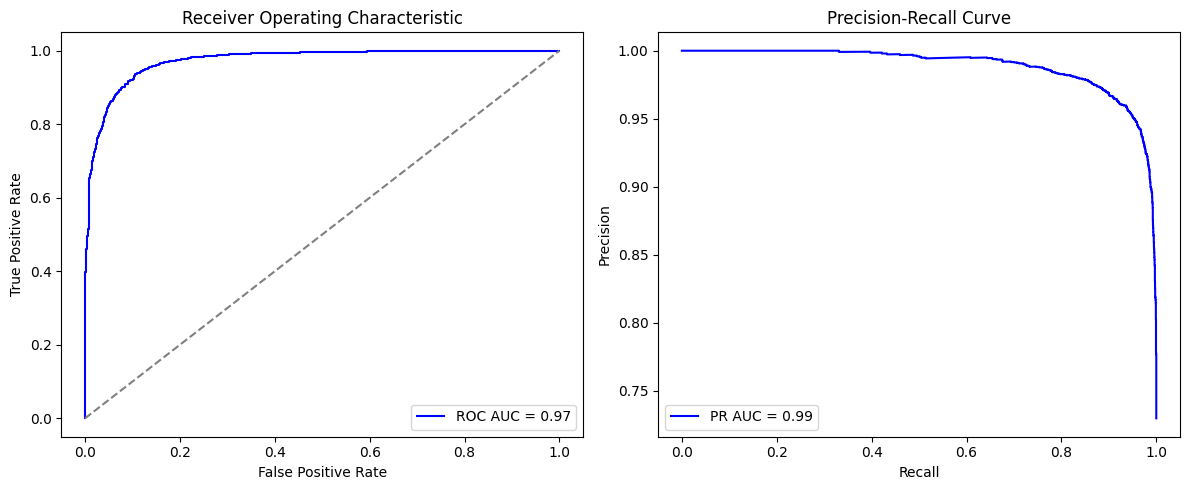

F1 Score: 0.9537438566059555
Epoch Validation Loss: 0.178397473692894
Epoch Validation Accuracy: 92.47863247863248
Epoch Validation Class Accuracy: {0: 74.68354430379746, 1: 99.06323185011709}




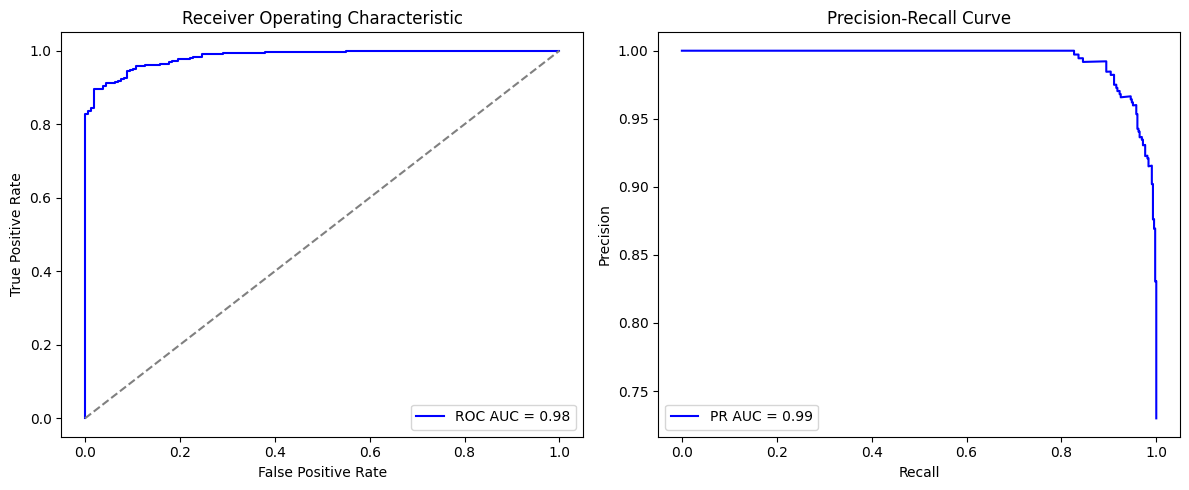

F1 Score: 0.9452513966480447
Model saved as 'chest_xray_model.pth'


In [ ]:
# Initialize the model
model = SimpleModel().to(device)

# Define loss function and optimizer
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

# Login and initialize for wandb configuration
api_key = '99ab401f6e1b998b75161f53b3fdc72bd919f645'
wandb.login(key=api_key)

config={
    "learning_rate": lr,
    "architecture": "SimpleModel",
    "epochs": num_epochs,
    "weight_decay": 0.0,
    "batch_size": batch_size,
    "shuffle": True,
    "loss": criterion
    }

wandb.init(project='Chest X-Ray Baseline Final', config=config)

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb
    )

# Save the model
torch.save(model.state_dict(), 'chest_xray_model.pth')
print("Model saved as 'chest_xray_model.pth'")

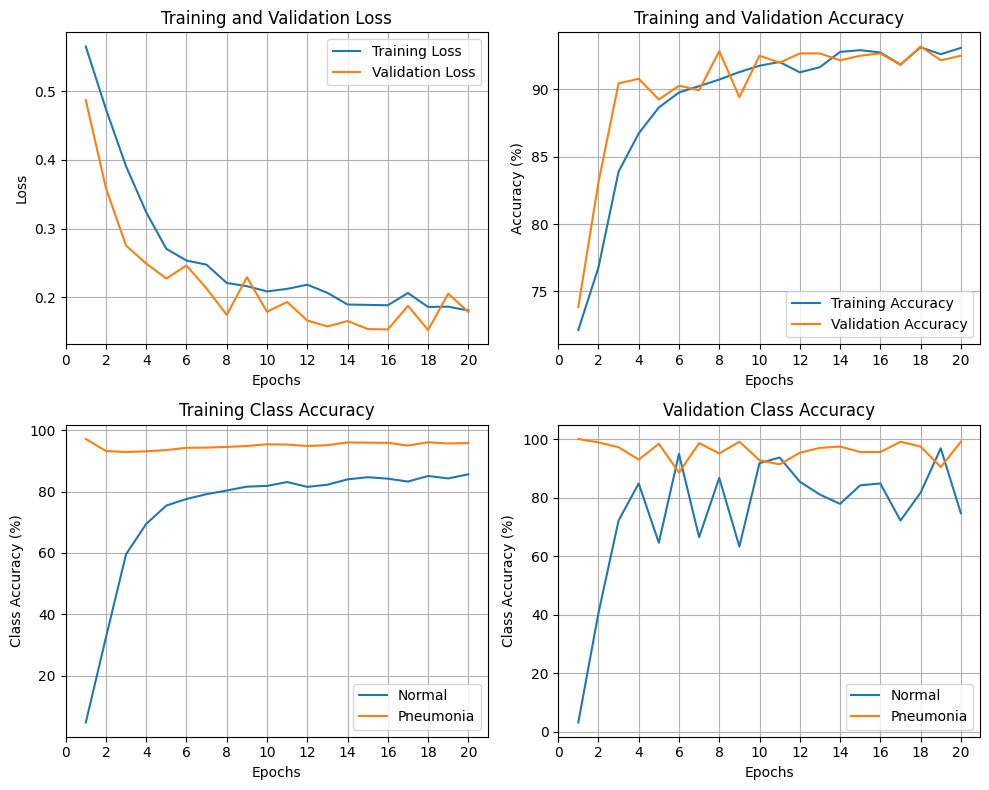

In [ ]:
# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

**(a)**

_Insert brief explanation of the design choices you made_

1. Set the learning rate to 0.01 as the learnings rates in the range of (0.01 - 0.001) are considered ideal for a baseline model
2. Used a 2 layer CNN and 1 layer prediction model:
   1. CNN Layer 1: 3 input channels, 16 kernels of each size 3x3, ReLU activation, and 2x2 Average Local Pooling
   2. CNN Layer 2: 16 input channels, 8 kernels of each size 3x3, ReLU activation
   3. Prediction layer: Flattened the output from previous CNN layer, and used a output layer of size 61x61x8 that does binary classification
3. These design choices of the neural network make the model quite lightweight, and interpretable. The model strikes a balance between simplicity and feature extraction capabilities, making it well-suited for the baseline
4. Used the Cross Entropy Loss function as it is a binary classification task, and chose commonly used Stochastic Gradient Descent as the optimizer

**(b)**

_Present your results, including plots etc. here_

1. Training:
   1. Final Epoch Accuracy: **93.06%**
   2. F1 Score: **0.954**
   3. Area under the Curve (AUC) for ROC Curve: **0.97**
   4. Area under the Curve (AUC) for Precision-Recall Curve: **0.99**
   5. Final Epoch Class Accuracies: **{Normal (Specificity): 85.62%, Pneumonia (Sensitivity): 95.81%}**
   6. Final Epoch Loss: **0.181**

2. Validation:
   1. Final Epoch Accuracy: **92.48%**
   2. F1 Score: **0.945**
   3. Area under the Curve (AUC) for ROC Curve: **0.98**
   4. Area under the Curve (AUC) for Precision-Recall Curve: **0.99**
   5. Final Epoch Class Accuracies: **{Normal (Specificity): 74.68%, Pneumonia (Sensitivity): 99.06%}**
   6. Final Epoch Loss: **0.178**

3. The ROC and Precision-Recall curves for training and validation datasets respectively are displayed above
4. The Loss, Accuracy, and Class Accuracies plots are also displayed above in the previous section

**(c)**

_Discuss your results here_

1. Training and Validation Loss:
   1. The validation loss converged to a lower value after epoch 10, buth there are still fluctuations
   2. Both final training and validation losses are low, indicating good learning by this simple lighweight model and consequently good performance making it ideal for a baseline
2. Training and Validation Accuracy:
   1. The training and validation accuracies are close to each other, indicating little to no overfitting, and both exceeding 90% show overall good performance for the baseline model
3. Training Class Accuracy:
   1. The 'Pnuemonia' class maintains quite accuracy throughout close to 100%, and 'Normal' class accuracy increases over epoch but saturates at a much lower value around 80%
   2. There is a clear gap between both the accuracies. This, along with the inital label distribution analysis, indicates that there is a class imabalance in favour of 'Pneumonia' class, and it is clearly affecting the model's capability to learn to predict 'Normal' class
4.  Validation Class Accuracy:
    1. The 'Normal' class variablility is quite high, fluctuating between ~60% and ~100%. The accuracy is very noisy for this class as opposed to the 'Pneumonia' class
5. Since the class is imbalanced, I calculated the F1 score in addition to the accuracy metric, as accuracy alone might not be the best metric to refer to for such cases. The ROC Curve curve and Precision-Recall curve have also been used to enhance the quality of the analysis. These metrics are especially useful for imbalanced datasets, where one class might dominate.

Overall the model performs good, with high accuracy, F1 score, and ROC & Precision-Recall AUC and low loss, but the 'Normal' class accuracy is suffering with high volatility and low value due to class imbalance. There are fluctuations in the validation loss as well. We need to address all these issues, and aim higher accuracy/F1/AUC and lower loss. This is something we want to achieve in the next section of improved model.

# Question 4: Improving the Baseline (50 marks)
After analysing the results of your baseline, can you spot any clear areas for improvement, or think of any obvious improvements to your model and training setup that will improve performance?

You are free to try out as many improvements as you want here. You may also try modifying aspects of the data.

**However, for the final code and results you present in your submission, you should use exactly 3 design choices which (attempt to) improve upon the baseline.**

Tips:
* If you struggle to improve upon the baseline, but your design choices are well motivated and well implemented, and your results are well-presented and discussed, you will still receive most marks here. You will get some extra marks for improving upon baseline performance, but you will primarily be marked for making reasonable design choices.
* A small number of marks will be deducted if there are extremely obvious issues with the baseline that you do not attempt to address

## Q 4.1: Final improved model -- baseline + 3 improvements (20 marks)



You should now choose three final improvements. Explain them, implement them, train a model, and present and discuss the results.

Try to maximize performance with the final three improvements you choose (i.e., pick the three best improvements you found).

In [19]:
# Implement the improvements and train the model in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################
batch_size = 128
lr = 1e-3

# Define the transform for augmenting the training Chest X-Ray images using ColourJitter and random blurring
aug_transform = transforms.Compose([
    transforms.Resize((resize_width, resize_height)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.ToTensor()
])

# Create the datasets
training_data_improved = ChestXrayDataset(dataset_path, 'train', aug_transform, use_aug=True)
validation_data_improved = ChestXrayDataset(dataset_path, 'val', transform)
testing_data_improved = ChestXrayDataset(dataset_path, 'test', transform)

# Create data loaders for the improved model with new transform
train_loader_improved = DataLoader(
    training_data_improved,
    batch_size = batch_size,
    shuffle = True
    )

val_loader_improved = DataLoader(
    validation_data_improved,
    batch_size = batch_size,
    shuffle = True
    )

test_loader_improved = DataLoader(
    testing_data_improved,
    batch_size = batch_size
    )

# Print dataset sizes
print(f"Training dataset size: {len(training_data)}")
print(f"Validation dataset size: {len(validation_data)}")
print(f"Test dataset size: {len(testing_data)}")

# Print batch shapes
print(f"Train Dataloader Shape: {next(iter(train_loader_improved))[0].shape}")
print(f"Validation Dataloader Shape: {next(iter(val_loader_improved))[0].shape}")
print(f"Test Dataloader Shape: {next(iter(test_loader_improved))[0].shape}")

Training dataset size: 4684
Validation dataset size: 585
Test dataset size: 587
Train Dataloader Shape: torch.Size([128, 3, 128, 128])
Validation Dataloader Shape: torch.Size([128, 3, 128, 128])
Test Dataloader Shape: torch.Size([128, 3, 128, 128])


In [21]:
class ImprovedCNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        #Convolutional Neural Netwrok Layer
        self.conv_layer_stack = nn.Sequential(

            # CNN Layer 1
            nn.Conv2d(3, 16, (3, 3), padding = 1),
            nn.LeakyReLU(1e-1),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),

            # CNN Layer 2
            nn.Conv2d(16, 8, (3, 3), padding = 1),
            nn.LeakyReLU(1e-1),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2),

            # CNN Layer 3
            nn.Conv2d(8, 16, (3, 3), padding = 1),
            nn.LeakyReLU(1e-1),
            nn.BatchNorm2d(16)
        )

        # Classification Layer for making predictions
        self.classification_layer = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(int(int(resize_width/2)/2)*int(int((resize_height)/2)/2)*16, 2)
        )

    def forward(self, x):
        x = self.conv_layer_stack(x)
        x = self.classification_layer(x)
        return x

In [22]:
improved_model = ImprovedCNNModel().to(device)

# Given that the class is highly imbalanced in favour of Penumonic images, we indroduce a class weight in the loss function to compensate for this imbalance
class_weights = [stats['train']['PNEUMONIA']/(2*stats['train']['NORMAL']), 1.0]
weights = torch.FloatTensor(class_weights).to(device)

criterion_improved = nn.CrossEntropyLoss(weight=weights)
optimizer_improved = torch.optim.Adam(improved_model.parameters(), lr)

# Use learning rate scheduler
scheduler = StepLR(optimizer_improved, step_size=2, gamma=0.1)

In [24]:
#Login and initialize for wandb configuration
api_key = '99ab401f6e1b998b75161f53b3fdc72bd919f645'
wandb.login(key=api_key)

config={
    "learning_rate": lr,
    "architecture": "ImprovedCNNModel",
    "epochs": num_epochs,
    "weight_decay": 0.0,
    "batch_size": batch_size,
    "shuffle": True,
    "loss": criterion_improved
    }

wandb.init(project='Chest X-Ray Improved', config=config)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tanishqpatil-sjp (tanishqpatil-sjp-university-college-london-ucl-). Use `wandb login --relogin` to force relogin


Epoch 1
-------------------------------
Epoch Train Loss: 0.46394746529089437
Epoch Train Accuracy: 87.36122971818958
Epoch Train Class Accuracy: {0: 81.04265402843602, 1: 89.70157987126974}


Epoch Validation Loss: 1.5716993808746338
Epoch Validation Accuracy: 34.52991452991453
Epoch Validation Class Accuracy: {0: 99.36708860759494, 1: 10.53864168618267}


Epoch 2
-------------------------------
Epoch Train Loss: 0.19122359156608582
Epoch Train Accuracy: 93.65926558497011
Epoch Train Class Accuracy: {0: 88.94154818325434, 1: 95.40667056758338}


Epoch Validation Loss: 0.772661292552948
Epoch Validation Accuracy: 73.16239316239316
Epoch Validation Class Accuracy: {0: 99.36708860759494, 1: 63.46604215456674}


Epoch 3
-------------------------------
Epoch Train Loss: 0.1075180938114991
Epoch Train Accuracy: 96.05038428693425
Epoch Train Class Accuracy: {0: 94.23380726698262, 1: 96.72322995904038}


Epoch Validation Loss: 0.09595846682786942
Epoch Validation Accuracy: 97.09401709401709
E

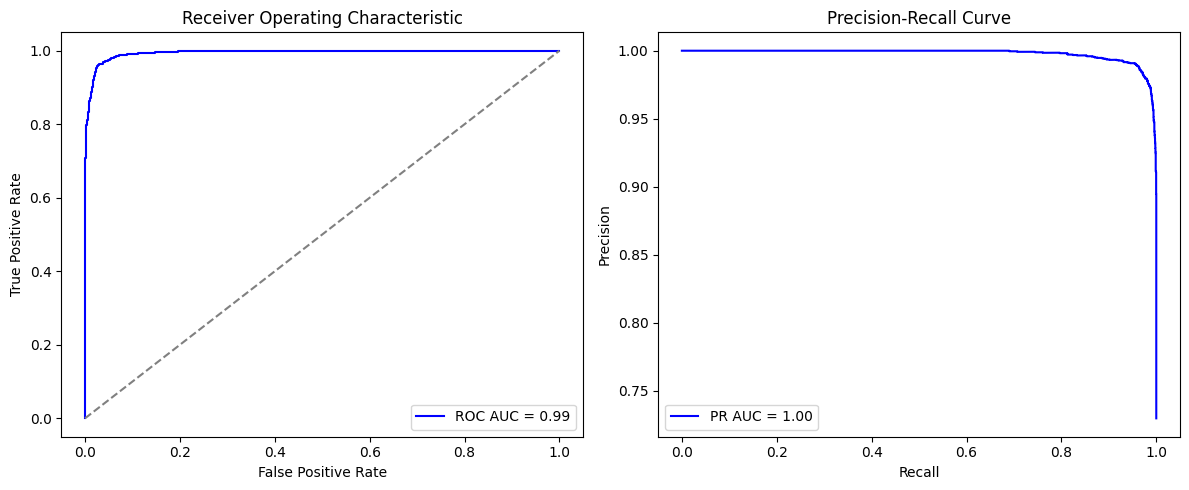

F1 Score: 0.9758768684327365
Epoch Validation Loss: 0.09531649872660637
Epoch Validation Accuracy: 97.43589743589743
Epoch Validation Class Accuracy: {0: 96.83544303797468, 1: 97.65807962529274}




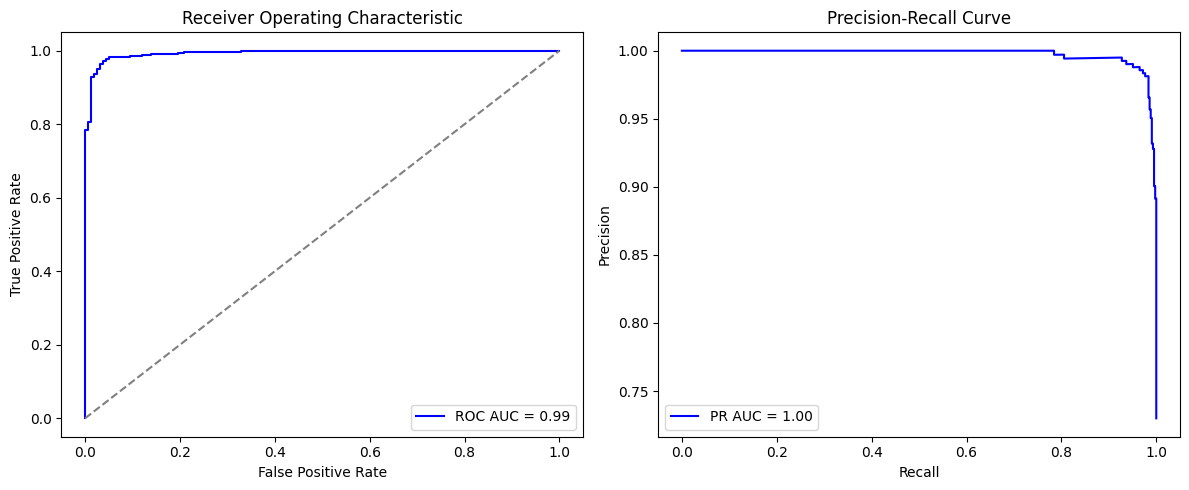

F1 Score: 0.9702026221692491
Model saved as 'chest_xray_improved_model.pth'


In [26]:
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
        improved_model, train_loader_improved, val_loader_improved, criterion_improved, optimizer_improved, num_epochs, device, use_wandb, scheduler=scheduler
        )

torch.save({
            'model_state_dict': improved_model.state_dict(),
            'optimizer_state_dict': optimizer_improved.state_dict(),
            }, 'chest_xray_improved_model.pth')
print("Model saved as 'chest_xray_improved_model.pth'")

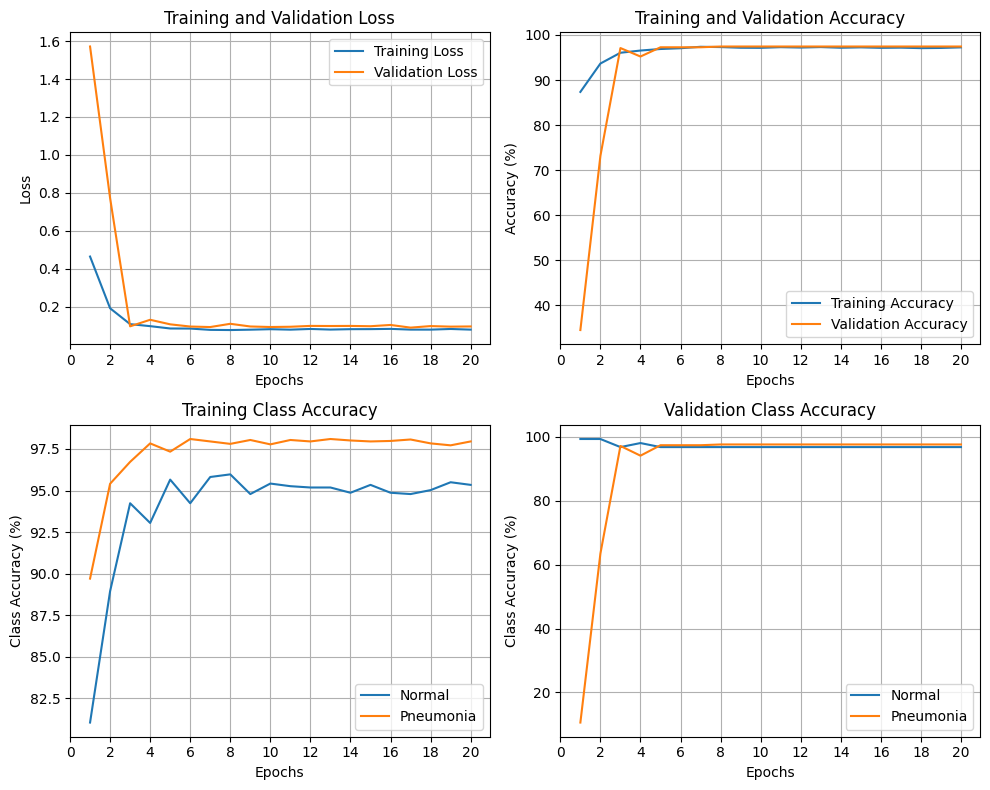

In [27]:
# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

**(a)**

*Insert a brief explanation of the three improvements you have used*

*For each improvment:*
1. *State the change being made;*
2. *State **why** this change could, in theory, improve the performance of the baseline model. If possible, motivate your hypothesis using empirical evidence from the baseline models results*


1. Improvement 1: Hyperparameter Tuning - Using learning rate scheduler and ADAM optimizer
   1. Changes made:
      1. Used the learning rate scheduler with initial value of 0.001, with step size 2 and gamma 0.1
      2. Used Adam optimizer instead to SGD

  2. Improvement justification:
      1. Learning Rate scheduler tend to improve the convergence stability of the loss function, and smoothens the it by removing the variance and fluctuations, in turn reducing the risk of overshooting
      2. Adam optimizer smoothens the parameters updates to remove the noise
      3. Empirical Evidence: Both the training and validation losses had the final value around 0.08-0.09 which is quite lower than the baseline, and little to no fluctuations which was not the case we saw earlier in the baseline.

2. Improvement 2: Using Data Augmentation and introducing class weights in Cross Entropy Loss Function
   1. Changes made:
      1. Used class weights to compensate for the class imabalance in the input dataset
      2. Added image augmentation to minority class 'Normal'
   2. Improvement Justification:
      1. Using class weights are quite essential when there is imabalance in the label classes. It gives the minority class higher weights encouraging the model to pay more attention to it, thus allowing it to reach the higher accuracies and F1 score in the validation
      2. Data augmentation for X-Ray images with randomly changing color, saturation, hue, brightness, and randomly adding blurring can help model generalise better on the minority class as it sees more diverse examples
      3. Empirical Evidence: The effect of class imbalance on class accuracies has been drastically reduced. When compared to the baseline, both the normal and pneumonia class accuracies are more stable for training and validation sets. Additionally, the normal class accuracy is hitting higher values thanks to the class weights and data augmentation. 'Normal' class accuracy is close to 95% in both training and validation sets as opposed to being close to 80% in the baseline

3. Improvement 3: Using a more complex neural network model containing additional CNN layers, Batch Normalization, Pooling, and Dropout
   1. Changes made:
      1. Added another layer of CNN (CNN Layer 3) and pooling
      2. Added Batch Normalisation to all the layers to standardise the data
   2. Improvement Justification:
      1. Additional CNN layer helps with the better feature extraction from the images and helps in building a more robust and accurate model capable of handling complex patterns
      2. Added another Pooling layer to reduce the computational burden and prevent overfitting by reducing the dimensionality of information extracted by the CNN layer
      3. Added Batch Normalization to all the three CNN layers. Batch Normalization leads to faster convergence, reduced variance, and better regularization on test data
      4. Added the Dropout in the classification layer to avoid overfitting in the model
      5. Empirical Evidence: The accuracy, F1 Score, and AUC all increased to higher values as a result of adding this complexity in the model. The F1 score increased to 0.970 in the improved model when compared with the score of 0.945 in the baseline. Additionally, the improved model saw lower loss and quicker convergence than the baseline model as evident from the plots.


**(b)**

_Present your results, including plots etc, here_

(Hint: ensure you compare to the baseline)

**Improved Model:**
1. Training:
   1. Final Epoch Accuracy: **97.25%**
   2. F1 Score: **0.976**
   3. Area under the Curve (AUC) for ROC Curve: **0.99**
   4. Area under the Curve (AUC) for Precision-Recall Curve: **1.00**
   5. Final Epoch Class Accuracies: **{Normal (Specificity): 95.34%, Pneumonia (Sensitivity): 97.95%}**
   6. Final Epoch Loss: **0.079**

2. Validation:
   1. Final Epoch Accuracy: **97.44%**
   2. F1 Score: **0.970**
   3. Area under the Curve (AUC) for ROC Curve: **0.99**
   4. Area under the Curve (AUC) for Precision-Recall Curve: **1.00**
   5. Final Epoch Class Accuracies: **{Normal (Specificity): 96.84%, Pneumonia (Sensitivity): 97.66%}**
   6. Final Epoch Loss: **0.095**

3. Comparison with baseline model:
   1. Both accuracy and F1 score increased in the improved model. We saw a bigger increase in validation accuracy from 92.48% in the baseline to 97.44% in the improved one
   2. The AUC for ROC and Precision-Recall curves increased too
   3. Most importantly, the 'Normal' class accuracy (specificity) on validation set increased from 74.68% to 96.84% in the improved model. This was quite significant as there was class imabalance in the input dataset
   4. Lastly, we were able to achieve even lower validation loss after the model was improved

4. The ROC and Precision-Recall curves for training and validation datasets respectively are displayed above
5. The Loss, Accuracy, and Class Accuracies plots are also displayed above in the previous section

**(c)**

_Discuss your results here_

1. Training and Validation Loss:
   1. The validation loss stabilized very quickly and converged to a stable value after 3 epochs, and there were no fluctuations after that
   2. Both final training and validation losses are quite low, indicating good learning by the model on the training set and good performance on the validation set
2. Training and Validation Accuracy:
   1. The training and validation accuracies are both quite high. The validation accuracy reached to the stable value of ~97-98% by 4 epochs and stayed constant thereafter
   2. Given that both the accuracies are close to each other, model is not overfitting, and is capable of having a good generalization on the test set
3. Training Class Accuracy:
   1. The huge clear gap that was visible between the accuracies of normal and pneumonia classes no longer exists after our explicit handling. The normal class has an accuracy of 95.34% in the improved model, which was 85.62% earlier in the baseline
   2. The model performs marginally better on the pneumonia class during training, but the overall accuracy for both the classes is quite high
4. Validation Class Accuracy:
   1. The model performs extremely well on both classes in the validation set, with near-perfect accuracy after just a few epochs. The model struggled initially with pneumonia class but it improved very rapidly
5. The model achieves very high F1 Scores for both training (0.976) and validation (0.970) datasets. Additionally the AUC scores were excellent, stating that our model has learned  well and is able to perform brilliantly on the validation set

Overall, the model performs excellently, with very high accuracy, F1 score, and ROC & Precision-Recall AUC and very low loss. The issue of low class accuracy due to class imbalance does not exist anymore, and our model is performing well on both the classes. The model converged quite quickly and had lower loss compared to th baseline.

## Q 4.2: Empirically justify improvement 1 (10 marks)

Now you will empirically demonstrate the contribution of each improvement to the final performance of your model.

To justify the utility of an improvement, you should present one of the following experiments:
- *Option 1:* Train the final model _without_ that improvement (but still with the other two improvements). Compare these results to the results you presented previously with all three improvements. If the improvement is useful, removing it should result in a drop in performance
- *Option 2:* Compare the performance of baseline to the perfroamnce of the baseline plus a single improvement. If the improvement is useful, you should expect improved performance versus the baseline.

You will still get a significant portion of the marks if the proposed improvement was well-motivated but does not empirically improve perfromance. In this case, ensure your discussion touches on why performance may not have improved or any other interesting talking points.


Epoch 1
-------------------------------
Epoch Train Loss: 0.22172125952469335
Epoch Train Accuracy: 91.60973526900085
Epoch Train Class Accuracy: {0: 81.43759873617694, 1: 95.37741369221767}


Epoch Validation Loss: 0.14848631024360656
Epoch Validation Accuracy: 93.5042735042735
Epoch Validation Class Accuracy: {0: 87.9746835443038, 1: 95.5503512880562}


Epoch 2
-------------------------------
Epoch Train Loss: 0.17220255229118708
Epoch Train Accuracy: 93.3603757472246
Epoch Train Class Accuracy: {0: 85.70300157977883, 1: 96.19660620245757}


Epoch Validation Loss: 0.14273794889450073
Epoch Validation Accuracy: 94.1880341880342
Epoch Validation Class Accuracy: {0: 88.60759493670886, 1: 96.25292740046838}


Epoch 3
-------------------------------
Epoch Train Loss: 0.15716663325155103
Epoch Train Accuracy: 94.0862510674637
Epoch Train Class Accuracy: {0: 87.04581358609795, 1: 96.69397308367466}


Epoch Validation Loss: 0.14048878401517867
Epoch Validation Accuracy: 94.35897435897436
Epo

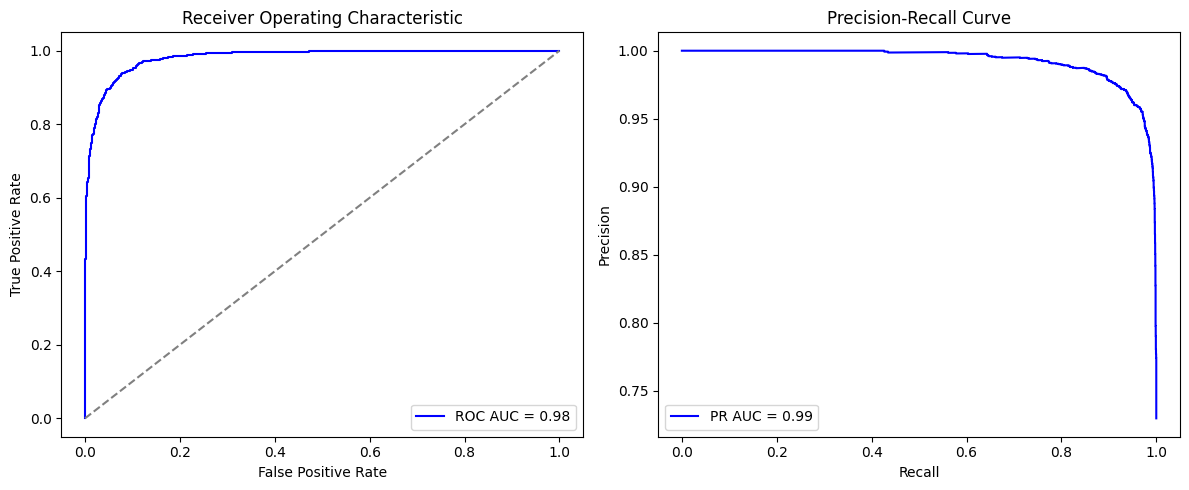

F1 Score: 0.9615495808037005
Epoch Validation Loss: 0.13849248886108398
Epoch Validation Accuracy: 94.1880341880342
Epoch Validation Class Accuracy: {0: 87.9746835443038, 1: 96.48711943793911}




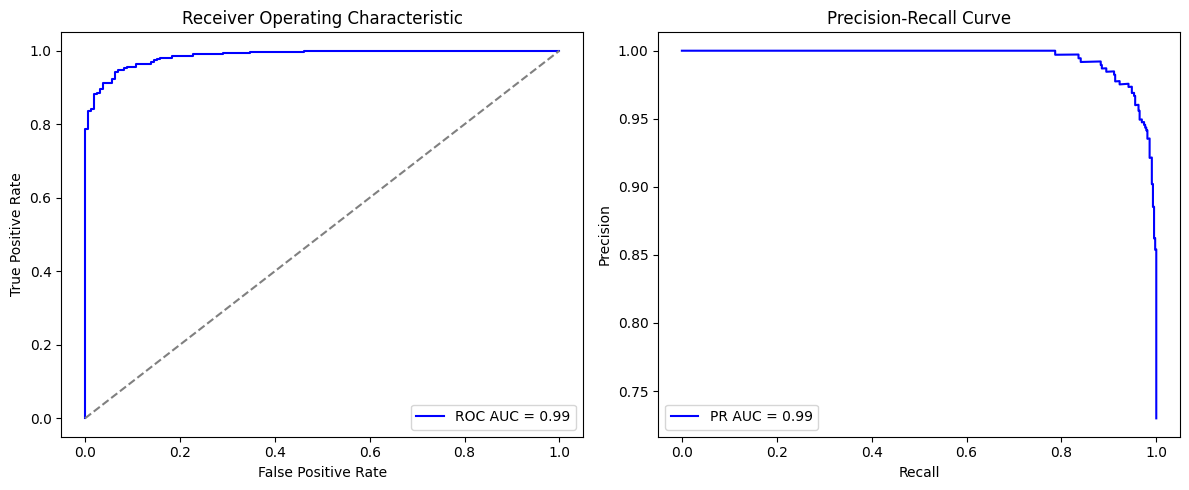

F1 Score: 0.9570267131242741


In [ ]:
# Implement the experiment in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

# Using Option 2
# Improvement 1 - Hyperparameter Tuning: Using learning rate scheduler and ADAM optimizer

batch_size = 128
lr = 1e-3
optimizer_eimp_1 = torch.optim.Adam(model.parameters(), lr)

train_loader_eimp_1 = DataLoader(
    training_data,
    batch_size = batch_size,
    shuffle = True
    )

val_loader_eimp_1 = DataLoader(
    validation_data,
    batch_size = batch_size,
    shuffle = True
    )

# Use learning rate scheduler
scheduler = StepLR(optimizer_eimp_1, step_size=2, gamma=0.1)

train_losses_eimp_1, train_accuracies_eimp_1, val_losses_eimp_1, val_accuracies_eimp_1, train_class_accuracies_eimp_1, val_class_accuracies_eimp_1 = train_model(
    model, train_loader_eimp_1, val_loader_eimp_1, criterion, optimizer_eimp_1, num_epochs, device, scheduler=scheduler)

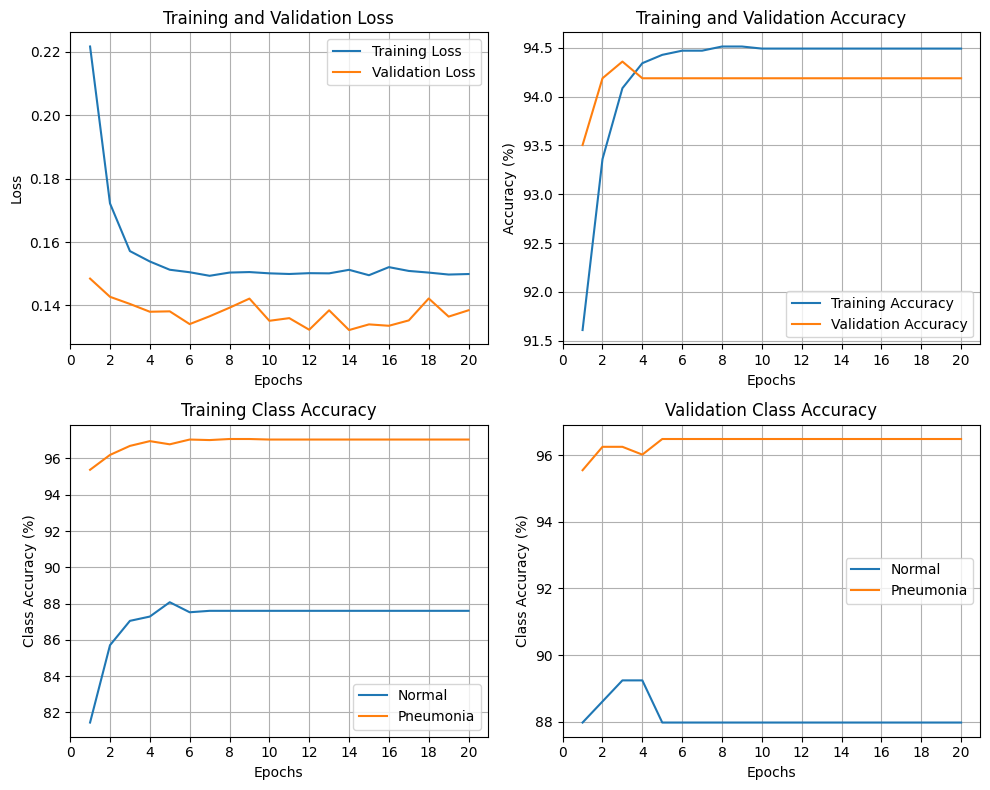

In [ ]:
# Plot training curves
plot_training_curves(train_losses_eimp_1, train_accuracies_eimp_1, val_losses_eimp_1, val_accuracies_eimp_1, train_class_accuracies_eimp_1, val_class_accuracies_eimp_1)

**(a)**

_State the improvement you are justifying_

**Improvement 1:**

Hyperparameter Tuning - Using learning rate scheduler and ADAM optimizer
   1. Changes made:
      1. Used the learning rate scheduler with initial value of 0.001, with step size 2 and gamma 0.1
      2. Used Adam optimizer instead to SGD

    
  2. Improvement justification:
      1. Learning Rate scheduler tend to improve the convergence stability of the loss function, and smoothens the it by removing the variance and fluctuations, in turn reducing the risk of overshooting
      2. Adam optimizer smoothens the parameters updates to remove the noise

**(b)**

_Present your results, including plots etc, here_

**Improvement 1:**

1. Training:
   1. Final Epoch Accuracy: **94.49%**
   2. F1 Score: **0.962**
   3. Area under the Curve (AUC) for ROC Curve: **0.98**
   4. Area under the Curve (AUC) for Precision-Recall Curve: **0.99**
   5. Final Epoch Class Accuracies: **{Normal (Specificity): 87.60%, Pneumonia (Sensitivity): 97.05%}**
   6. Final Epoch Loss: **0.150**

2. Validation:
   1. Final Epoch Accuracy: **94.19%**
   2. F1 Score: **0.957**
   3. Area under the Curve (AUC) for ROC Curve: **0.99**
   4. Area under the Curve (AUC) for Precision-Recall Curve: **0.99**
   5. Final Epoch Class Accuracies: **{Normal (Specificity): 87.97%, Pneumonia (Sensitivity): 96.49%}**
   6. Final Epoch Loss: **0.139**

3. The ROC and Precision-Recall curves for training and validation datasets respectively are displayed above
4. The Loss, Accuracy, and Class Accuracies plots are also displayed above in the previous section


**(c)**

_Discuss your results here_

**Improvement 1:**

1. Both the training and validation losses had the final value around 0.14-0.15 which is lower than the baseline, and there are slight fluctuations but quite less than what we saw earlier in the baseline
2. The loss function converged better with this improvement than it did in the baseline

## Q 4.3: Empirically justify improvement 2 (10 marks)

Epoch 1
-------------------------------
Epoch Train Loss: 0.1393574856825777
Epoch Train Accuracy: 94.94022203245089
Epoch Train Class Accuracy: {0: 91.15323854660348, 1: 96.34289057928613}


Epoch Validation Loss: 0.1325461357831955
Epoch Validation Accuracy: 94.7008547008547
Epoch Validation Class Accuracy: {0: 94.30379746835443, 1: 94.84777517564403}


Epoch 2
-------------------------------
Epoch Train Loss: 0.13529955958192413
Epoch Train Accuracy: 95.21776259607174
Epoch Train Class Accuracy: {0: 91.4691943127962, 1: 96.60620245757752}


Epoch Validation Loss: 0.1253633141517639
Epoch Validation Accuracy: 96.06837606837607
Epoch Validation Class Accuracy: {0: 89.24050632911393, 1: 98.59484777517564}


Epoch 3
-------------------------------
Epoch Train Loss: 0.13594115062339887
Epoch Train Accuracy: 95.23911187019641
Epoch Train Class Accuracy: {0: 91.23222748815166, 1: 96.72322995904038}


Epoch Validation Loss: 0.12187585681676864
Epoch Validation Accuracy: 96.06837606837607
Ep

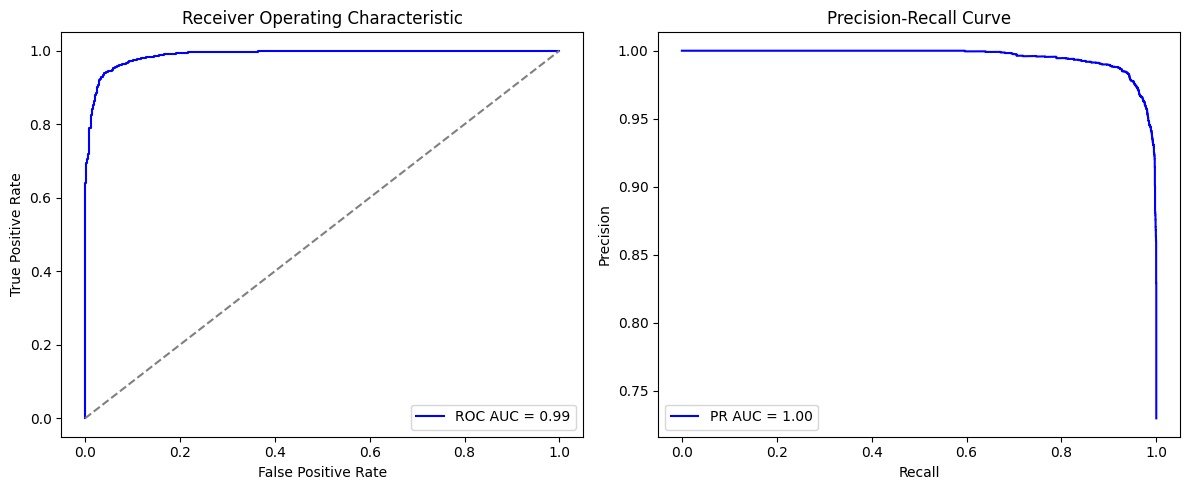

F1 Score: 0.9683350357507661
Epoch Validation Loss: 0.1241155207157135
Epoch Validation Accuracy: 95.38461538461539
Epoch Validation Class Accuracy: {0: 95.56962025316456, 1: 95.31615925058549}




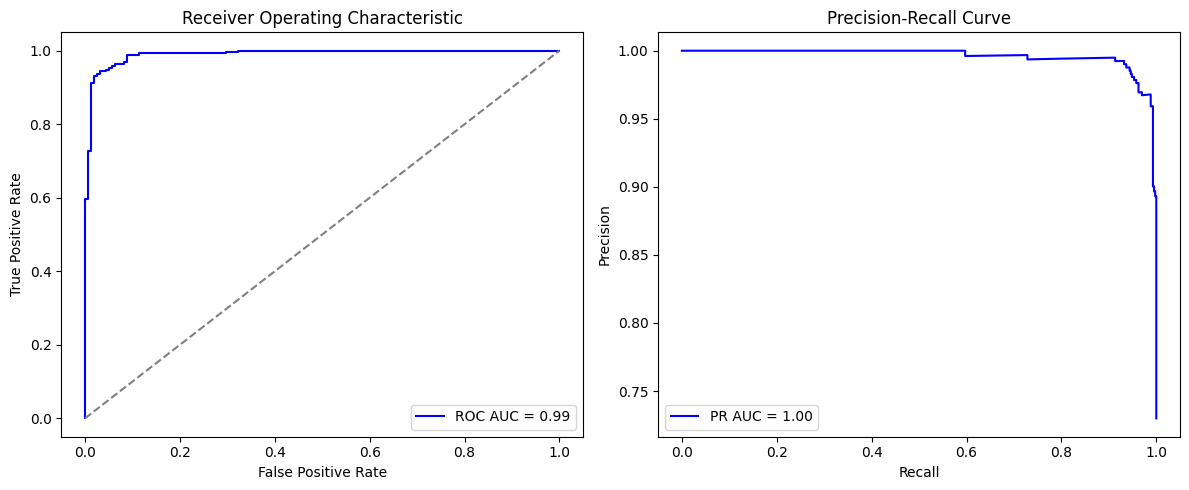

F1 Score: 0.966824644549763


In [ ]:
# Implement the experiment in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

# Using Option 2
# Improvement 2: Using Data Augmentation and introducing class weights in Cross Entropy Loss Function

train_loader_eimp_2 = DataLoader(
    training_data_improved,
    batch_size = batch_size,
    shuffle = True
    )

val_loader_eimp_2 = DataLoader(
    validation_data_improved,
    batch_size = batch_size,
    shuffle = True
    )

train_losses_eimp_2, train_accuracies_eimp_2, val_losses_eimp_2, val_accuracies_eimp_2, train_class_accuracies_eimp_2, val_class_accuracies_eimp_2 = train_model(
    model, train_loader_eimp_2, val_loader_eimp_2, criterion_improved, optimizer, num_epochs, device)

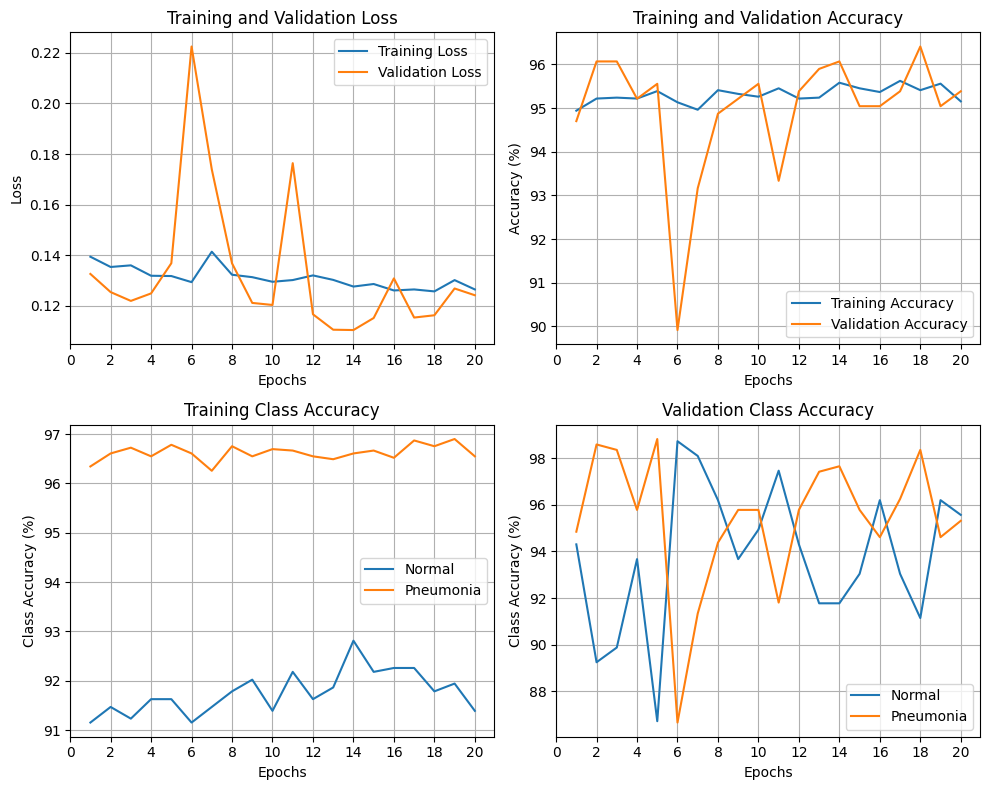

In [ ]:
# Plot training curves
plot_training_curves(train_losses_eimp_2, train_accuracies_eimp_2, val_losses_eimp_2, val_accuracies_eimp_2, train_class_accuracies_eimp_2, val_class_accuracies_eimp_2)

**(a)**

_State the improvement you are justifying_

**Improvement 2:**

Using Data Augmentation and introducing class weights in Cross Entropy Loss Function
   1. Changes made:
      1. Used class weights to compensate for the class imabalance in the input dataset
      2. Added image augmentation to minority class 'Normal'
   2. Improvement Justification:
      1. Using class weights are quite essential when there is imabalance in the label classes. It gives the minority class higher weights encouraging the model to pay more attention to it, thus allowing it to reach the higher accuracies and F1 score in the validation
      2. Data augmentation for X-Ray images with randomly changing color, saturation, hue, brightness, and randomly adding blurring can help model generalise better on the minority class as it sees more diverse examples

**(b)**

_Present your results, including plots etc, here_

**Improvement 2:**

1. Training:
   1. Final Epoch Accuracy: **95.15%**
   2. F1 Score: **0.968**
   3. Area under the Curve (AUC) for ROC Curve: **0.99**
   4. Area under the Curve (AUC) for Precision-Recall Curve: **1.00**
   5. Final Epoch Class Accuracies: **{Normal (Specificity): 91.39%, Pneumonia (Sensitivity): 96.55%}**
   6. Final Epoch Loss: **0.126**

2. Validation:
   1. Final Epoch Accuracy: **95.39%**
   2. F1 Score: **0.967**
   3. Area under the Curve (AUC) for ROC Curve: **0.99**
   4. Area under the Curve (AUC) for Precision-Recall Curve: **1.00**
   5. Final Epoch Class Accuracies: **{Normal (Specificity): 95.57%, Pneumonia (Sensitivity): 95.32%}**
   6. Final Epoch Loss: **0.124**

3. The ROC and Precision-Recall curves for training and validation datasets respectively are displayed above
4. The Loss, Accuracy, and Class Accuracies plots are also displayed above in the previous section


**(c)**

_Discuss your results here_

**Improvement 2:**
1. The effect of class imbalance on class accuracies has been drastically reduced. When compared to the baseline, both the normal and pneumonia class accuracies are more stable for training and validation sets
2. Additionally, the normal class accuracy is hitting higher values thanks to the class weights and data augmentation. 'Normal' class accuracy is close to 95% on the validation set and 91% on the training set as opposed to being close to 80% in the baseline

## Q 4.4: Empirically justify improvement 3 (10 marks)

Epoch 1
-------------------------------
Epoch Train Loss: 5.368622519679971
Epoch Train Accuracy: 75.44833475661828
Epoch Train Class Accuracy: {0: 60.66350710900474, 1: 80.92451726155646}


Epoch Validation Loss: 0.2382088154554367
Epoch Validation Accuracy: 94.87179487179488
Epoch Validation Class Accuracy: {0: 91.77215189873418, 1: 96.01873536299766}


Epoch 2
-------------------------------
Epoch Train Loss: 0.5813219249248505
Epoch Train Accuracy: 90.9265584970111
Epoch Train Class Accuracy: {0: 83.41232227488152, 1: 93.70977179637215}


Epoch Validation Loss: 0.27414621859788896
Epoch Validation Accuracy: 93.16239316239316
Epoch Validation Class Accuracy: {0: 97.46835443037975, 1: 91.56908665105387}


Epoch 3
-------------------------------
Epoch Train Loss: 0.35044274579834295
Epoch Train Accuracy: 93.38172502134927
Epoch Train Class Accuracy: {0: 87.28278041074249, 1: 95.64072557050908}


Epoch Validation Loss: 2.8189960956573485
Epoch Validation Accuracy: 67.17948717948718
Epo

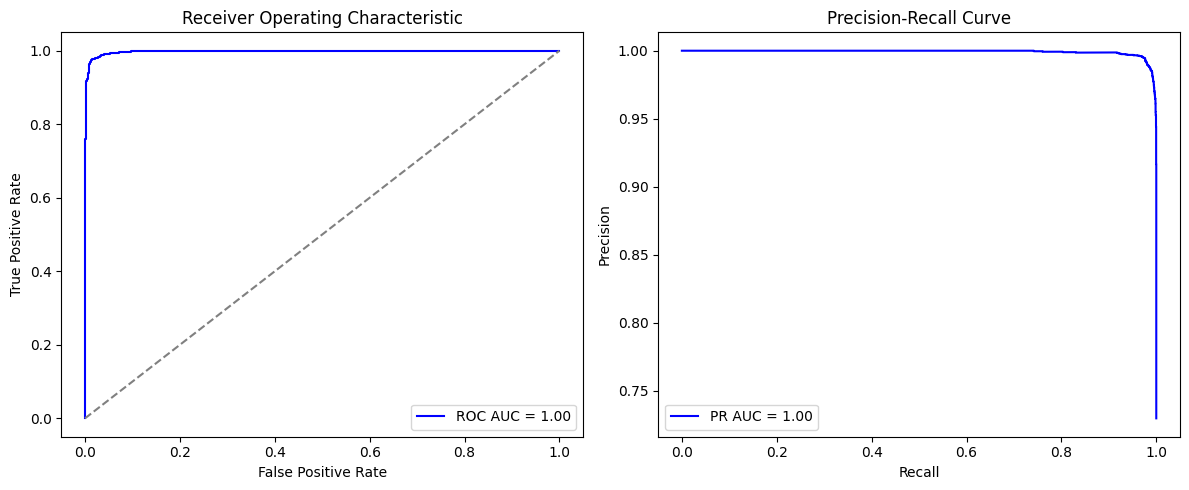

F1 Score: 0.9854518736223365
Epoch Validation Loss: 0.09050207398831844
Epoch Validation Accuracy: 96.41025641025641
Epoch Validation Class Accuracy: {0: 93.0379746835443, 1: 97.65807962529274}




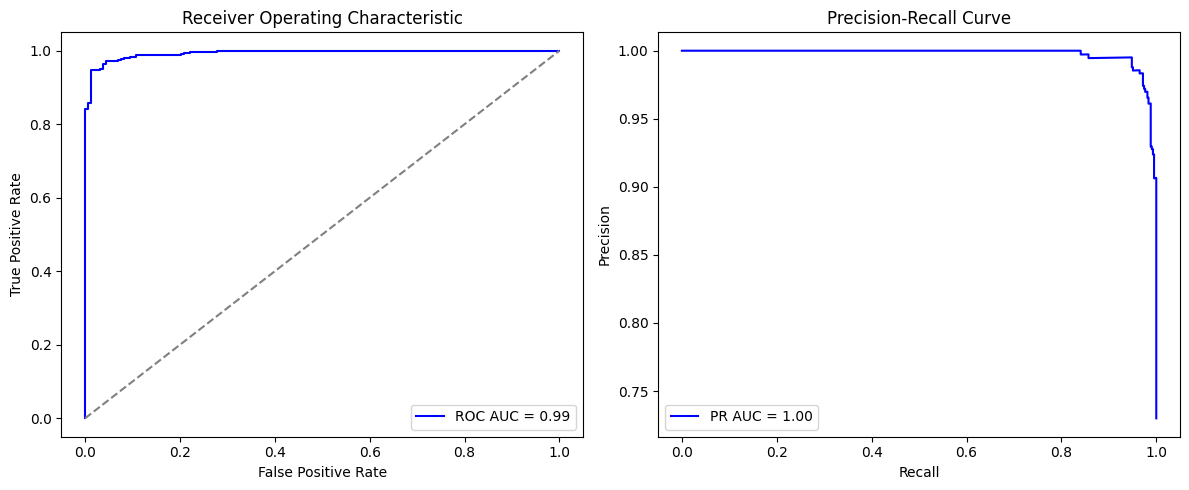

F1 Score: 0.9753231492361927


In [ ]:
# Implement the experiment in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################
# Using Option 2
# Improvement 3: Using a more complex neural network model containing additional CNN layers, Batch Normalization, Pooling, and Dropout

# Resetting the lr to same as the baseline, and using the baseline optimizer with improved_model's parameters
lr = 1e-2
optimizer = torch.optim.SGD(improved_model.parameters(), lr)

train_losses_eimp_3, train_accuracies_eimp_3, val_losses_eimp_3, val_accuracies_eimp_3, train_class_accuracies_eimp_3, val_class_accuracies_eimp_3 = train_model(
    improved_model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

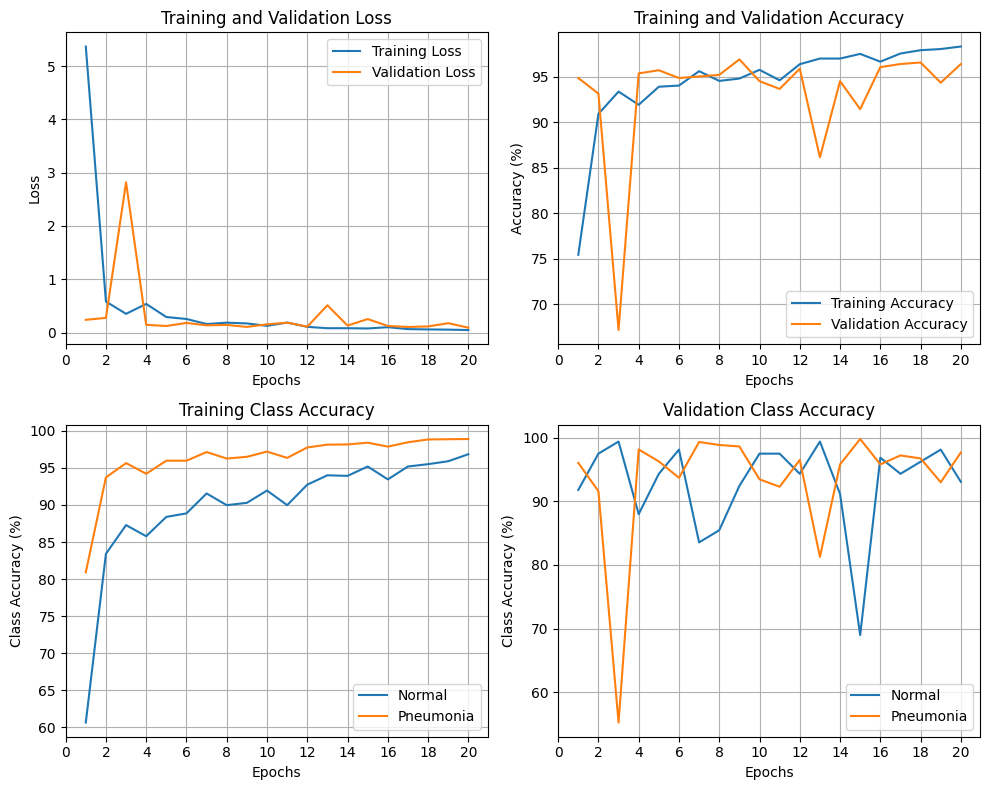

In [ ]:
# Plot training curves
plot_training_curves(train_losses_eimp_3, train_accuracies_eimp_3, val_losses_eimp_3, val_accuracies_eimp_3, train_class_accuracies_eimp_3, val_class_accuracies_eimp_3)

**(a)**

_State the improvement you are justifying_

**Improvement 3:**

Using a more complex neural network model containing additional CNN layers, Batch Normalization, Pooling, and Dropout
   1. Changes made:
      1. Added another layer of CNN (CNN Layer 3) and pooling
      2. Added Batch Normalisation to all the layers to standardise the data
   2. Improvement Justification:
      1. Additional CNN layer helps with the better feature extraction from the images and helps in building a more robust and accurate model capable of handling complex patterns
      2. Added another Pooling layer to reduce the computational burden and prevent overfitting by reducing the dimensionality of information extracted by the CNN layer
      3. Added Batch Normalization to all the three CNN layers. Batch Normalization leads to faster convergence, reduced variance, and better regularization on test data
      4. Added the Dropout in the classification layer to avoid overfitting in the model

**(b)**

_Present your results, including plots etc, here_

**Improvement 3:**

1. Training:
   1. Final Epoch Accuracy: **98.33%**
   2. F1 Score: **0.986**
   3. Area under the Curve (AUC) for ROC Curve: **0.99**
   4. Area under the Curve (AUC) for Precision-Recall Curve: **1.00**
   5. Final Epoch Class Accuracies: **{Normal (Specificity): 96.84%, Pneumonia (Sensitivity): 98.89%}**
   6. Final Epoch Loss: **0.046**

2. Validation:
   1. Final Epoch Accuracy: **96.41%**
   2. F1 Score: **0.975**
   3. Area under the Curve (AUC) for ROC Curve: **0.99**
   4. Area under the Curve (AUC) for Precision-Recall Curve: **1.00**
   5. Final Epoch Class Accuracies: **{Normal (Specificity): 93.04%, Pneumonia (Sensitivity): 97.66%}**
   6. Final Epoch Loss: **0.091**

3. The ROC and Precision-Recall curves for training and validation datasets respectively are displayed above
4. The Loss, Accuracy, and Class Accuracies plots are also displayed above in the previous section


**(c)**

_Discuss your results here_

**Improvement 3:**

1. The accuracy, F1 Score, and AUC all increased to higher values as a result of adding this complexity to the model
2. The F1 score increased to 0.975 with this improvement when compared with the score of 0.945 in the baseline
3. Additionally, this improvement saw lower loss and quicker convergence than the baseline model which is evident from the plots

# Question 5: Final Evaluation (10 marks)

You should perform a final evaluation of the performance of your model


Epoch Test Loss: 0.19073470532894135
Epoch Test Accuracy: 94.8892674616695
Epoch Test Class Accuracy: {0: 91.82389937106919, 1: 96.02803738317758}




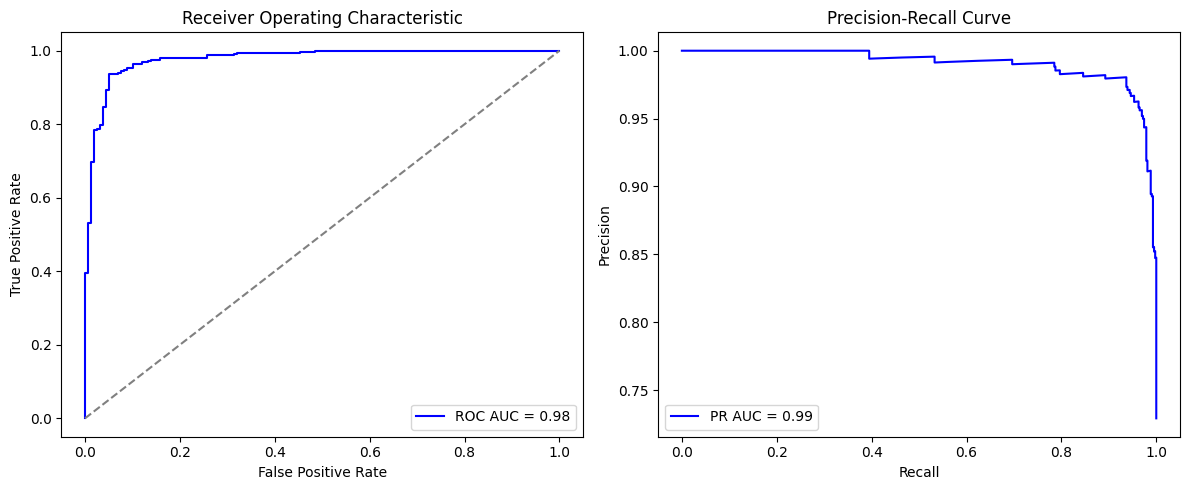

F1 Score: 0.9562130177514793


In [23]:
# Implement evaluation here

########################################################################
#                              YOUR CODE HERE                          #
########################################################################
test_improved_model = torch.load('chest_xray_improved_model.pth', weights_only=True)
improved_model.load_state_dict(test_improved_model['model_state_dict'])
test_loss, test_accuracy, test_class_accuracy = val_test_model('Test', improved_model, test_loader_improved, criterion_improved, device, use_wandb=False, plot_cls_metrics=True)

**(a)**

_Present your results, including plots etc, here_

**Test Results:**
   1. Test Accuracy: **94.89%**
   2. F1 Score: **0.956**
   3. Area under the Curve (AUC) for ROC Curve: **0.98**
   4. Area under the Curve (AUC) for Precision-Recall Curve: **0.99**
   5. Test Class Accuracies: **{Normal (Specificity): 91.82%, Pneumonia (Sensitivity): 96.03%}**
   6. Test Loss: **0.191**
   7. The ROC and Precision-Recall curve for the test dataset in displayed above

**(b)**

_Discuss your results here_

**Test Results:**

1. The model shows high overall accuracy of 94.88%
2. Both the class accuracies are high, suggesting balanced performance across the two classes
3. The ROC AUC score of 0.98 indicates excellent classification performance. The model has a high ability to distinguish between the two classes - Normal vs Pneumonia
4. The PR AUC score of 0.99 further confirms the excellent performance of the model, indicating high precision and high recall
5. High F1 score of 0956 suggests the model is very good at both correctly identifying Pneumonia and avoiding false positives
6. The loss value is quite low as well which indicates that model is making very few errors in the prediction

Overall, the model performed the pneumonia classification task very well on the unseen test data, and can generalize well on newer data as evident from these test metrics.